## Helper functions

In [1]:
"""Imports"""
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

from cot import Collection
import yaml

In [2]:
# Helper functions to call OpenAI model, system also generates reasoning
# this function lets the model reason (less frequently used than system_evaluate)

def system_experiment(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\nwith the following answer options:{answer_options}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_generate(input_dict)

def save_as_yaml(data, filepath):
    with open(filepath, 'w') as file:
        yaml.dump(data, file)

In [3]:
def system_evaluate(data,model, path_system_template):
    chat = ChatOpenAI(
        temperature=0,
        model_name=model,
        request_timeout=600,
        max_retries=1,
    )

    human_template="""Answer the question:{question}\n
    with the following answer options:{answer_options}\n
    Reasoning: {reasoning}\n
    Answer: {answer}"""
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)
    
    with open(path_system_template, 'r') as file:
        template = file.read()
    system_message_prompt = SystemMessagePromptTemplate.from_template(template)
    
    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])  
    input_dict = {'chat':chat,'chat_prompt':chat_prompt, "api_time_interval": 1} 
    
    return data.system_eval(input_dict)

In [4]:
import pandas as pd
import yaml

def process_new_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    for item in new_data[dataset][split]:
        try:
            scores_per_item.append(yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader))
        except:
            print("wrong output found")
            continue

    # Get unique keys from all dictionaries
    keys = set().union(*scores_per_item)

    # Create lists of values for each key
    scores_per_objective = {key: [d.get(key) for d in scores_per_item] for key in keys if key != "critique"} #added critique

    #check values for nonetype
    for key, value in scores_per_objective.items():
        if value is not str:
            print(key,value)


    # Calculate the average of each list
    averaged_data = {key: sum(value) / len(value) for key, value in scores_per_objective.items() if key!="critique"} #added critique

    # Convert the averaged data dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(averaged_data, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df = df.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11']]

    return scores_per_item, scores_per_objective, df

In [5]:
def parse_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    for item in new_data[dataset][split]:
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            if any(isinstance(v, str) for v in data.values()):
                new_dict = {k: v for k, v in data.items() if k.startswith('obj')}
                scores_per_item.append(new_dict)
                variables_per_item.append(data)
            else:
                scores_per_item.append(data)
        except:
        
            print("wrong output found")
            continue
    return scores_per_item, variables_per_item

In [6]:
def parse_lst_data(new_data,idx_cot,dataset,split):
    scores_per_item = []
    variables_per_item = []
    statements_per_item = []
    for item in new_data[dataset][split]:
        try:
            data = yaml.load(item['generated_cot'][idx_cot]['cot'], Loader=yaml.FullLoader)
            #if any(isinstance(v, str) for v in data.values()):
            new_dict = {k: v[1] for k, v in data.items() if k.startswith('obj')}
            statement_dict = {k: v[0] for k, v in data.items() if k.startswith('obj')}
            statements_per_item.append(statement_dict)
            scores_per_item.append(new_dict)
            variables_per_item.append(data)
            # else:
            #     scores_per_item.append(data)
        except:
        
            print("wrong output found")
            continue
    return scores_per_item, variables_per_item, statements_per_item


In [7]:
def get_further_data(scores_per_item):
# Get unique keys from all dictionaries
    keys = set().union(*scores_per_item)

    # Create lists of values for each key
    scores_per_objective = {key: [d.get(key) for d in scores_per_item] for key in keys}
    # scores_per_objective = {k: v for k, v in scores_per_objective.items() if not isinstance(v, str)}
    # print(scores_per_objective)

    # #check values for nonetype
    # for key, value in scores_per_objective.items():
    #     if value is not str:
    #         #print(key,value)
    #         continue


    # Calculate the average of each list
    #averaged_data = {key: sum(value) / len(value) for key, value in scores_per_objective.items()} 
    averaged_data = {key: (sum(v for v in value if v is not None) / len([v for v in value if v is not None])) for key, value in scores_per_objective.items() if len([v for v in value if v is not None]) > 0}

    # Convert the averaged data dictionary to a Pandas DataFrame
    df = pd.DataFrame.from_dict(averaged_data, orient='index', columns=['Average'])

    # Sort the DataFrame by the index (row labels)
    df = df.loc[['obj_1', 'obj_2', 'obj_3', 'obj_4', 'obj_5', 'obj_6', 'obj_7', 'obj_8', 'obj_9', 'obj_10', 'obj_11']]

    return scores_per_objective, df

In [8]:
def fix_none_score(scores_per_item):
    for i,element in enumerate(scores_per_item):
        for inner_key, value in element.items():
            if value is None:
                scores_per_item[i][inner_key] = 5
    return scores_per_item
    

In [9]:
def fix_str_score(scores_per_item):
    for i,element in enumerate(scores_per_item):
        for inner_key, value in element.items():
            if isinstance(value,str):
                scores_per_item.pop(i)
    return scores_per_item

In [10]:
#helper functions for results
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statistics

def freq_bar_plot(scores_per_item): #later better axes
    average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
    # Create a histogram
    plt.hist(average_per_item, bins='auto', alpha=0.7)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Frequency of average score per item')
    plt.show()

def avg_item_plot(scores_per_objective):  #later better axes
 
    data = scores_per_objective
    averaged_data = {key: sum(value) / len(value) for key, value in data.items() if key!="critique"} #added "critique"
    sorted_data = {k: v for k, v in sorted(averaged_data.items())}

    # Extract the keys (objectives) and values (averages) from the sorted dictionary
    keys = sorted_data.keys()
    values = sorted_data.values()

    # Create a bar plot
    plt.bar(keys, values)
    plt.xlabel('Objectives')
    plt.ylabel('Average')
    # plt.ylim(7,10)
    plt.title('Average per Objective')
    plt.xticks(rotation=45)
    plt.show()

def avg_true_false(data,average_per_item,dataset,split):
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = average_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

    print("scores true:", statistics.mean(scores_true))
    print("scores false:", statistics.mean(scores_false))

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Prompts with simple grading do not work 

In [86]:
med_zhou = Collection.from_json("med_qa_zhou_eval.json")


In [95]:
#for template 13 "There is room for improvement prompt"
absolute_path = "./reflection_messages/input_system/system_template_13_eval.yaml"
system_evaluate(med_zhou,'gpt-3.5-turbo',absolute_path)
med_zhou.dump("med_qa_template_13")
output = process_new_data(med_zhou,idx_cot=1)
print(output)

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 63: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID c6cc1cdfbeec9baabfe3f7008406cf6f in your message.)
Retrying with additional time of 10 seconds.
wrong output found
wrong output found
         Average
obj_1   9.122449
obj_2   9.836735
obj_3   9.000000
obj_4   9.500000
obj_5   8.836735
obj_6   9.295918
obj_7   9.234694
obj_8   9.724490
obj_9   8.918367
obj_10  9.285714
obj_11  9.683673


In [100]:
#template 12 "the average score of the objectives should usually be at most 7-8."
absolute_path = "./reflection_messages/input_system/system_template_12_eval.yaml"
system_evaluate(med_zhou,'gpt-3.5-turbo',absolute_path)
med_zhou.dump("med_qa_template_12")
output = process_new_data(med_zhou,idx_cot=1)
print(output)

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 88: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID d334e30cbc2755eaf79a8e06d350a18e in your message.)
Retrying with additional time of 10 seconds.


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

wrong output found
         Average
obj_1   8.242424
obj_2   9.141414
obj_3   8.202020
obj_4   8.747475
obj_5   7.787879
obj_6   8.141414
obj_7   8.252525
obj_8   9.070707
obj_9   7.757576
obj_10  8.141414
obj_11  9.000000


In [ ]:
#Generate with template 14

absolute_path = "/Users/robertpraas/Desktop/ThoughtSource/notebooks/reflection_messages/input_system/system_template_14_eval.yaml"
system_evaluate(medqa_total,'gpt-4',absolute_path)
medqa_total.dump("med_qa_gpt_4_template_14") 
scores_per_item, scores_per_objective, df = process_new_data(medqa_total,idx_cot=1)


In [23]:
df

,Average
obj_1,10.000000
obj_2,9.710526
obj_3,9.973684
obj_4,9.736842
obj_5,9.947368
obj_6,9.710526
obj_7,8.710526
obj_8,10.000000
obj_9,9.131579
obj_10,9.973684


## Writing about statements makes AI more critical

In [94]:
#test for bigger dataset
from cot import Collection
cohere = Collection.from_json("./med_qa_zhou_cohere.json")
cohere.select_generated_cots(answer=False)
cohere_false = cohere.filter(lambda x: len(x["generated_cot"])==1)
cohere_false = cohere_false.select(split="test", number_samples=15, random_samples=True, seed=0)

cohere_false


| Name   | Train   | Valid   |   Test |
|--------|---------|---------|--------|
| med_qa | -       | -       |     15 |

Not loaded: ['aqua', 'asdiv', 'commonsense_qa', 'entailment_bank', 'gsm8k', 'mawps', 'med_qa_open', 'medmc_qa', '_init_', 'mmlu_clinical_knowledge', 'mmlu_college_biology', 'mmlu_college_medicine', 'mmlu_medical_genetics', 'mmlu_professional_medicine', '_init_', 'mmlu_anatomy', 'open_book_qa', 'pubmed_qa', 'qed', 'strategy_qa', 'svamp', 'worldtree']

In [100]:
absolute_path = "./input_system/system_template_15_eval.yaml"
system_evaluate(cohere_false,'gpt-3.5-turbo',absolute_path)

Generating med_qa...


In [ ]:
cohere_false.dump("cohere_false_check")

In [117]:
#which data here?
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)

         Average
obj_1   5.771739
obj_2   7.347826
obj_3   5.978261
obj_4   5.347826
obj_5   5.239130
obj_6   5.923913
obj_7   5.467391
obj_8   6.260870
obj_9   4.271739
obj_10  5.673913
obj_11  5.782609


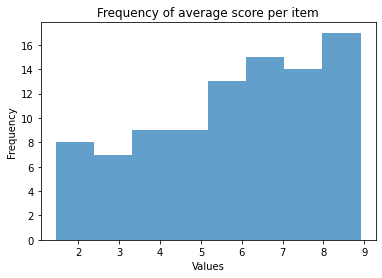

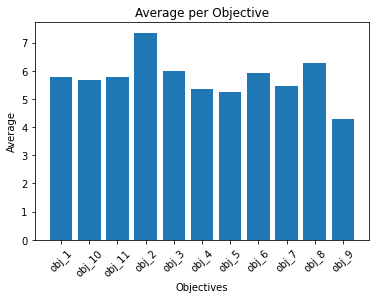

In [128]:
# Low score: critical on datasets with bad samples
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [129]:
# try the same without writing context

absolute_path = "./input_system/system_template_14_eval.yaml"
system_evaluate(cohere_false,'gpt-3.5-turbo',absolute_path)


Generating med_qa...


In [132]:
scores_per_item, variables_per_item = parse_data(cohere_false,idx_cot=2,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)

         Average
obj_1   9.066667
obj_2   9.600000
obj_3   8.066667
obj_4   9.000000
obj_5   7.933333
obj_6   8.733333
obj_7   8.733333
obj_8   9.466667
obj_9   7.933333
obj_10  8.866667
obj_11  9.533333


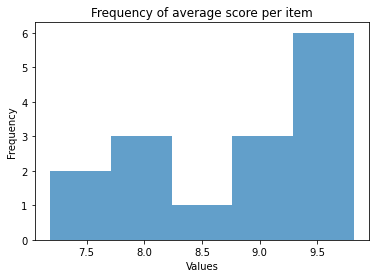

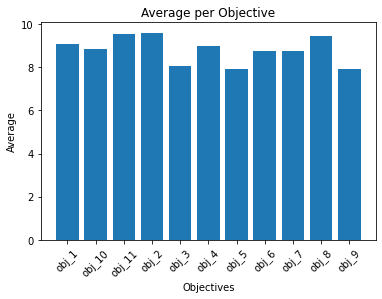

In [133]:
# That model gives way too high scores
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [ ]:
#Now test if giving a legend of grades works as well

In [134]:
absolute_path = "./input_system/system_template_18.yaml"
system_evaluate(cohere_false,'gpt-3.5-turbo',absolute_path)
cohere_false.dump("medqa_cohere_template_15_14_18")

Generating med_qa...


In [135]:
scores_per_item, variables_per_item = parse_data(cohere_false,idx_cot=3,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)

         Average
obj_1   8.600000
obj_2   9.266667
obj_3   7.733333
obj_4   8.400000
obj_5   7.333333
obj_6   8.066667
obj_7   7.600000
obj_8   8.933333
obj_9   7.466667
obj_10  8.333333
obj_11  9.333333


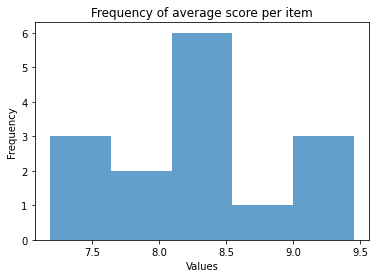

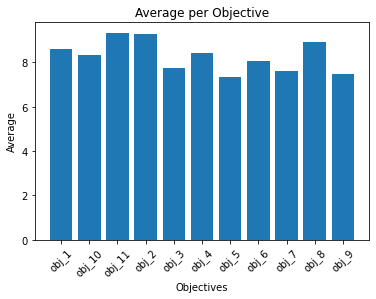

In [136]:
#(Partially)
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [ ]:
"""This setting:

critique: <Write a short critique about the reasoning>
obj_1: <1-10>
obj_2: <1-10>"""

In [149]:
absolute_path = "./input_system/system_template_20.yaml"
system_evaluate(cohere_false,'gpt-3.5-turbo',absolute_path)


Generating med_qa...


In [150]:
scores_per_item, variables_per_item = parse_data(cohere_false,idx_cot=5,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)

         Average
obj_1   6.400000
obj_2   8.066667
obj_3   6.266667
obj_4   6.066667
obj_5   5.466667
obj_6   6.400000
obj_7   5.800000
obj_8   6.733333
obj_9   4.866667
obj_10  6.333333
obj_11  6.400000


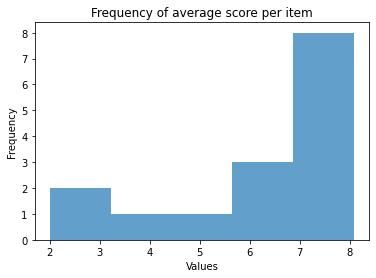

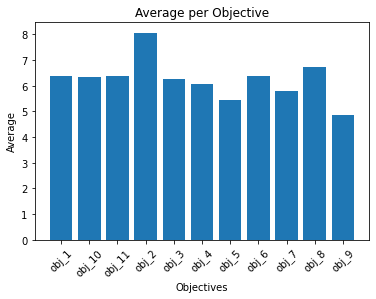

In [151]:
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [30]:
data = Collection.from_json("cohere_false_check")
absolute_path = "./input_system/system_template_20b.yaml"
system_evaluate(cohere_false,'gpt-3.5-turbo',absolute_path)

## GPT-4 assess itself

In [21]:
data = Collection.from_json("medqa_false_gpt_4.json")
absolute_path = "./input_system/system_template_20.yaml"
data = data.select(split="test", number_samples=10, random_samples=True, seed=0)
system_evaluate(data,'gpt-4',absolute_path)
data.dump("gpt_4_false_critique")

Generating med_qa...


  0%|          | 0/10 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [22]:
data = Collection.from_json("gpt_4_false_critique")

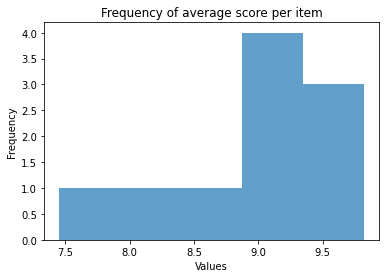

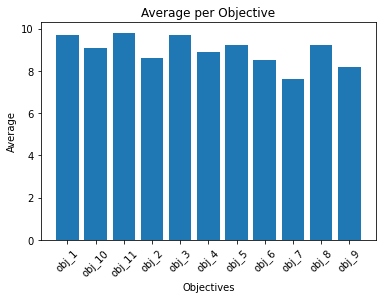

In [28]:
# How to translate subtle differences to better output?

scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [10]:
med_qa_true = Collection.from_json("/Users/robertpraas/Desktop/ThoughtSource/notebooks/reflection_messages/med_qa_zhou_eval_gpt4.json")
med_qa_true.select_generated_cots(answer=True)
med_qa_true = med_qa_true.filter(lambda x: len(x["generated_cot"])==1)

In [12]:
absolute_path = "./input_system/system_template_20.yaml"
med_qa_true = med_qa_true.select(split="test", number_samples=10, random_samples=True, seed=0)
system_evaluate(med_qa_true,'gpt-4',absolute_path)
med_qa_true.dump("gpt_4_true_critique")

Generating med_qa...


In [24]:
med_qa_true = Collection.from_json("gpt_4_true_critique")

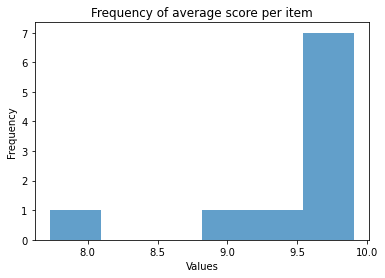

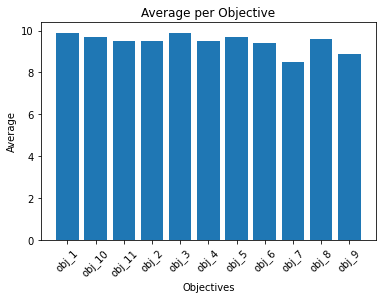

In [29]:
scores_per_item, variables_per_item = parse_data(med_qa_true,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df_2 = get_further_data(scores_per_item)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [27]:
from IPython.display import display_html

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw=True)

# Assuming df1 and df2 are your dataframes
display_side_by_side(df, df_2)

#False, Correct

,Average
obj_1,9.7
obj_2,8.6
obj_3,9.7
obj_4,8.9
obj_5,9.2
obj_6,8.5
obj_7,7.6
obj_8,9.2
obj_9,8.2
obj_10,9.1


In [ ]:
# GPT-4 on GPT-4
data = Collection.from_json("medqa_false_gpt_4.json")
absolute_path = "./input_system/system_template_23.yaml"
system_evaluate(data,'gpt-4',absolute_path)
data.dump("gpt_4_false_critique_indicator")

         Average
obj_1   9.473684
obj_2   8.421053
obj_3   9.526316
obj_4   8.736842
obj_5   9.263158
obj_6   8.578947
obj_7   7.578947
obj_8   9.052632
obj_9   8.052632
obj_10  9.105263
obj_11  9.736842


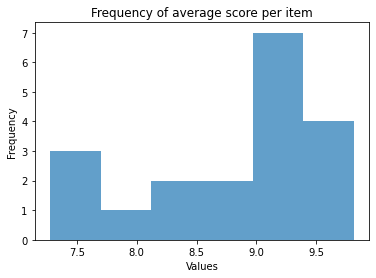

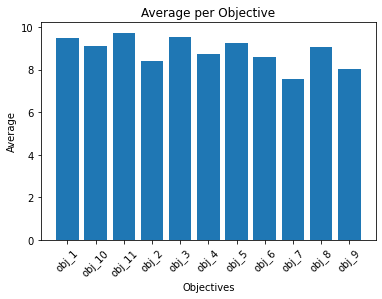

In [ ]:
# GPT-4 cannot say answer should be changed (annotator)

data = Collection.from_json("gpt_4_false_critique_indicator")
# How to translate subtle differences to better output?

scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

## 3.5 corrects Cohere: shows 12,14,16 does not work

         Average
obj_1   9.030928
obj_2   9.556701
obj_3   8.061856
obj_4   8.865979
obj_5   7.948454
obj_6   8.690722
obj_7   8.628866
obj_8   9.237113
obj_9   7.927835
obj_10  8.680412
obj_11  9.298969
scores true: 8.733333333333333
scores false: 8.71506105834464


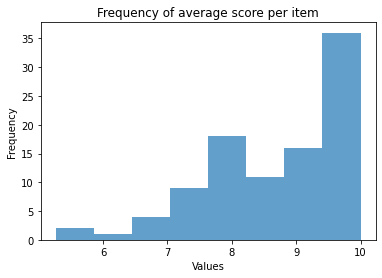

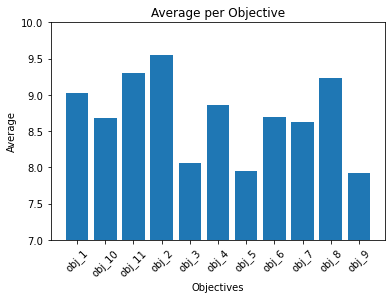

In [30]:
# This way ChatGPT does not correct cohere in anyway, need to ask it to dig deeper/more concrete
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
avg_true_false(med_co,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

## Let system generate and rate itself

In [ ]:
#system experiment
#rate error!!

path = "./input_system/system_template_17.yaml"
data = Collection.load_thoughtsource_100(names = ['medmc_qa'],load_pregenerated_cots=False)
system_experiment(data,'gpt-3.5-turbo', path)
data.dump("medmc_template_17")

# GPT-4 scores high on questions it has wrong

data = Collection.from_json("medmc_template_17")
# How to translate subtle differences to better output?

scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

## Ignore

In [39]:
from cot import Collection
med_co = Collection.from_json("med_qa_zhou_cohere.json")
# med_co = med_co.select(split="test", number_samples=5, random_samples=True, seed=0)


In [32]:
absolute_path = "./input_system/system_template_16_improve.yaml"
system_evaluate(med_co,'gpt-3.5-turbo',absolute_path)


Generating med_qa...


  0%|          | 0/5 [00:00<?, ?ex/s]

In [41]:
absolute_path = "./input_system/system_template_16_improve.yaml"
system_evaluate(med_co,'gpt-3.5-turbo',absolute_path)

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 3: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID ec4033ca79513c56921a4c5a91dde67e in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 17: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 83d987a460cff5dcda0bf041d64a3c64 in your message.)
Retrying with additional time of 10 seconds.


In [42]:
med_co.dump("full_chatgpt_cohere_correction")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [43]:
absolute_path = "./input_system/system_template_16_improve.yaml"
system_evaluate(med_co,'gpt-4',absolute_path)

Generating med_qa...


  0%|          | 0/100 [00:00<?, ?ex/s]

(API-)Error in item 31: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID f7933b7535f23c4a9629ef0929a6e0ba in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 60: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID d91af4f8bc51adbb8c70853969ebf927 in your message.)
Retrying with additional time of 10 seconds.
(API-)Error in item 94: HTTP code 502 from API (<html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
<hr><center>cloudflare</center>
</body>
</html>
)
Retrying with additional time of 10 seconds.


In [44]:
med_co.dump("gpt_3_4_cohere_correction")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [48]:
med_co['med_qa']['test'][0]

{'id': 'med_qa_test_2',
 'ref_id': '',
 'question': 'Two weeks after undergoing an emergency cardiac catherization with stenting for unstable angina pectoris, a 61-year-old man has decreased urinary output and malaise. He has type 2 diabetes mellitus and osteoarthritis of the hips. Prior to admission, his medications were insulin and naproxen. He was also started on aspirin, clopidogrel, and metoprolol after the coronary intervention. His temperature is 38°C (100.4°F), pulse is 93/min, and blood pressure is 125/85 mm Hg. Examination shows mottled, reticulated purplish discoloration of the feet. Laboratory studies show:\nHemoglobin count 14 g/dL\nLeukocyte count 16,400/mm3\nSegmented neutrophils 56%\nEosinophils 11%\nLymphocytes 31%\nMonocytes 2%\nPlatelet count 260,000/mm3\nErythrocyte sedimentation rate 68 mm/h\nSerum\nUrea nitrogen 25 mg/dL\nCreatinine 4.2 mg/dL\nRenal biopsy shows intravascular spindle-shaped vacuoles. Which of the following is the most likely cause of this patient\

In [89]:
med_co = Collection.from_json("gpt_3_4_cohere_correction")

In [ ]:
#this does not work - write data.map function

In [76]:
str = """corrected_reasoning: 
The given reasoning is correct.

final_answer: C."""
str = str.replace("corrected_reasoning: \n", "corrected_reasoning: ")
yaml_data = yaml.load(str, Loader=yaml.FullLoader)
yaml_data['final_answer']

'C.'

In [ ]:
gpt_4_test = Collection.from_json("/Users/robertpraas/Desktop/ThoughtSource/notebooks/internal_documentation/paper_2/filtered_thoughtsource_100_gpt-4_None_false.json")
gpt_4_test

## Run / next steps

In [ ]:
#Look into average objectives per true and false answers

#rewrite this

# assign item correct, incorrect, loop over every item 11 times to extract a specific 
def avg_true_false(data,scores_per_item,dataset,split):
    item_correct = []
    for item in data[dataset][split]:
        item_correct.append(item['generated_cot'][0]['answers'][0]['correct_answer'])

    # Example lists of scores and indicators
    scores = average_per_item
    indicators = item_correct

    # Separate scores based on indicators
    scores_true = [score for score, indicator in zip(scores, indicators) if indicator]
    scores_false = [score for score, indicator in zip(scores, indicators) if not indicator]

In [ ]:
# systematically also try open_book (medmc?)

In [ ]:
# generate larger experiments with
# Models
# Which templates: 
# naive one - 12 /  legend -  18
# short critique (strong), long list - 20
# short citique, short list - 20b (uneven ones)

# Data: Openbook and MedQA
# how many data points worth it?: propose 150 each
# 300 data points

# 3600 calls - 1800 from Chatgpt (and 1800 from GPT-4 = ~64)

# 3.5 on cohere 
# 3.5 on 3.5
# 4 on 3.5
# 4 on 4 - if costs allow

# Metrics:

# Average objective score
# Average item score
# average objectives/item scores per true and false answers









## GPT-4 improves GPT-3.5

In [186]:
absolute_path = "./input_system/system_template_20.yaml"
system_evaluate(medqa_data,'gpt-4',absolute_path)

Generating med_qa...


  0%|          | 0/30 [00:00<?, ?ex/s]

         Average
obj_1   9.500000
obj_2   8.966667
obj_3   9.566667
obj_4   8.800000
obj_5   9.166667
obj_6   8.866667
obj_7   8.000000
obj_8   8.966667
obj_9   8.233333
obj_10  9.033333
obj_11  9.033333
scores true: 9.333333333333334
scores false: 7.95959595959596


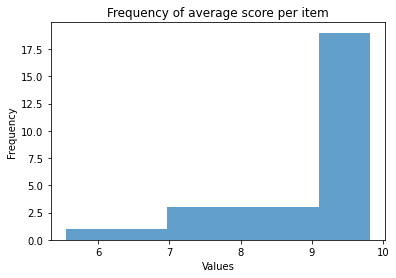

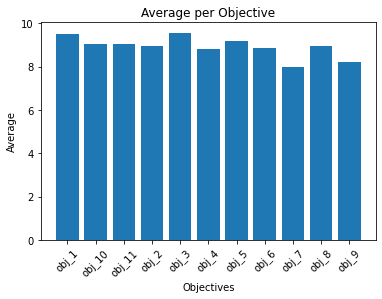

In [214]:
scores_per_item, variables_per_item = parse_data(medqa_data,idx_cot=2,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
avg_true_false(medqa_data,average_per_item,'med_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [187]:
medqa_data.dump("medqa_4_on_3_template_15_20")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

         Average
obj_1   9.400000
obj_2   8.566667
obj_3   9.833333
obj_4   8.800000
obj_5   9.266667
obj_6   8.833333
obj_7   7.766667
obj_8   8.666667
obj_9   8.466667
obj_10  8.933333
obj_11  8.966667
scores true: 9.024793388429751
scores false: 8.420454545454545


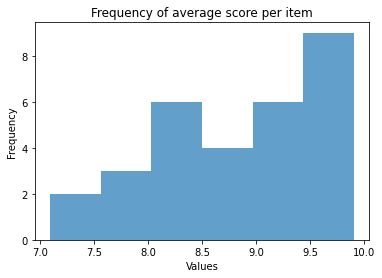

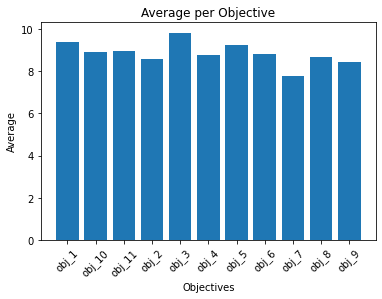

In [227]:
scores_per_item, variables_per_item = parse_data(medmc_data,idx_cot=2,dataset='open_book_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
print(df)
average_per_item = [sum(d.values()) / len(d) for d in scores_per_item]
avg_true_false(medmc_data,average_per_item,'open_book_qa','test')
freq_bar_plot(scores_per_item)
avg_item_plot(scores_per_objective)

In [193]:
medmc_data.dump("medmc_4_on_3_template_15_20")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

## Iteration likert etc

In [ ]:
#- Floating point difference or percentage

# - Variance & span
# - Statistical analysis

# - Meaning scores + reasoning = why messy
# - GPT-4 comparison

# - Med dataset?

## float vs percentage

In [ ]:
#floating point number between -1 and 1 

In [32]:
"./reflection_messages/input_system/system_template_20c.yaml"

0.1

In [77]:
data = Collection.from_json("./prelim_output/med_qa_zhou_cohere.json")
path = "./input_system/system_template_20d.yaml"
data = data.select(split="test", number_samples=10, random_samples=True, seed=0)
system_evaluate(data,'gpt-3.5-turbo',path)

Generating med_qa...


  0%|          | 0/10 [00:00<?, ?ex/s]

In [78]:
path = "./input_system/system_template_20e.yaml"
system_evaluate(data,'gpt-3.5-turbo',path)
data.dump("floating_vs_percentage")

Generating med_qa...


  0%|          | 0/10 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [51]:
path = "./input_system/system_template_20e.yaml"
system_evaluate(data,'gpt-3.5-turbo',path)
data.dump("20e_percentage")

Generating med_qa...


  0%|          | 0/10 [00:00<?, ?ex/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [69]:
data['med_qa']['test'][8]['generated_cot'][1]

{'id': 'd47622ce-eae7-4aba-9358-8f509c2d8f3e',
 'fragments_version': '0.01',
 'instruction': '',
 'cot_trigger': '',
 'cot_trigger_template': '',
 'prompt_text': '',
 'cot': 'critique: The reasoning is concise and accurate, but it lacks detail and does not consider all relevant information.\nobj_1: 0.8\nobj_2: 0.7\nobj_3: 0.8\nobj_4: 0.7\nobj_5: 0.8\nobj_6: 0.6\nobj_7: 0.7\nobj_8: 0.8\nobj_9: 0.7\nobj_10: 0.8\nobj_11: 0.9',
 'answers': [{'id': '304772a7-8e71-4331-ae93-9584794f185a',
   'answer_extraction': '',
   'answer_extraction_template': '',
   'answer_extraction_text': '',
   'answer': '',
   'answer_from_choices': '',
   'correct_answer': None}],
 'author': '',
 'date': '2023/05/31 14:52:30',
 'api_service': '',
 'model': "{'name': '', 'temperature': 0, 'max_tokens': 1600}",
 'comment': '',
 'annotations': []}

In [ ]:
#calculate variance of percentage and floating point
# conversion: ((0,3 + 1) / 2) * 100

In [ ]:
#data (floating point, percentage)

In [79]:
scores_per_item, variables_per_item = parse_data(data,idx_cot=2,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
standard_deviation(scores_per_objective)

{'obj_3': 29.8561365365462,
 'obj_8': 33.66914182320528,
 'obj_1': 32.72783388968954,
 'obj_6': 29.10230995031914,
 'obj_10': 30.555050500876465,
 'obj_4': 33.76799931559135,
 'obj_2': 27.708803254160543,
 'obj_7': 30.663949154956832,
 'obj_11': 46.20004810002306,
 'obj_5': 31.989581637360207,
 'obj_9': 35.103022978402045}

In [81]:
# Floating again throws out percentages once
scores_per_item, variables_per_item = parse_data(data,idx_cot=1,dataset='med_qa',split='test')
scores_per_item = fix_str_score(scores_per_item)
scores_per_objective, df = get_further_data(scores_per_item)
standard_deviation(scores_per_objective)
#floating point outlier issue

{'obj_3': 23.522433736518185,
 'obj_8': 15.69331421692407,
 'obj_1': 15.660583925540223,
 'obj_6': 15.647775844793053,
 'obj_10': 15.65781310116809,
 'obj_4': 15.667095738805225,
 'obj_2': 23.4905300067921,
 'obj_7': 15.6174546225974,
 'obj_11': 23.55039277804088,
 'obj_5': 15.65490338520171,
 'obj_9': 15.694036376209205}

In [75]:
import math

def standard_deviation(data):
    # First, compute the mean for each key.
    mean_data = {key: sum(value) / len(value) for key, value in data.items()}
    
    # Then, for each key, compute the sum of the squared differences from the mean.
    variance_data = {}
    for key, value in data.items():
        variance_data[key] = sum((x - mean_data[key]) ** 2 for x in value) / (len(value)-1)
    
    # Finally, compute the standard deviation for each key.
    standard_deviation_data = {key: math.sqrt(value) for key, value in variance_data.items()}
    
    return standard_deviation_data

def standard_deviation_floating(data):
    # First, compute the mean for each key.
    #mean_data = {key: sum(((value + 1) / 2) * 100) / len(value) for key, value in data.items()}
    #mean_data = {key: ((sum(value) / len(value) + 1) / 2) * 100 for key, value in data.items()}
    mean_data = {key: ((sum(v) / len(v) + 1) / 2) * 100 for key, values in data.items() 
             for v in values if -1 <= v <= 1}
    
    # Then, for each key, compute the sum of the squared differences from the mean.
    variance_data = {}
    # for key, value in data.items():
    #     try:
    #         variance_data[key] = sum((x - mean_data[key]) ** 2 for x in value) / (len(value)-1)
    #     except KeyError:
    #         print(f'Key {key} not found in mean_data. Skipping.')
            
    # # Finally, compute the standard deviation for each key.
    # standard_deviation_data = {key: math.sqrt(value) for key, value in variance_data.items()}

    # return standard_deviation_data
    for key, value in data.items():
        variance_data[key] = sum((x - mean_data[key]) ** 2 for x in value) / (len(value)-1)
    
    # Finally, compute the standard deviation for each key.
    standard_deviation_data = {key: math.sqrt(value) for key, value in variance_data.items()}
    
    return standard_deviation_data

## The range of certain scores

In [ ]:
data = scores_per_objective
span_data = {key: (min(value),max(value)) for key, value in data.items() 
                 if all(-1 <= v <= 1 for v in value)}